In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler

In [2]:
default_cycler = cycler(color=['firebrick', 'green'])
plt.rc('axes', prop_cycle=default_cycler)

In [3]:
from firing_signals.sampling.bffs import backward_filtering_forward_sampling

In [4]:
# LMS algorithm
# conjugate gradient descent

In [5]:
def hamming_dist(seq1, seq2):
    return np.sum(seq1 != seq2)

In [6]:
n, Nr = 20, 1
m = 30

# Logistic regression

The link function is
\begin{equation}
h_{w, \theta}(z_k) = \frac{1}{1 + \exp (- w^\top z_k + \theta)}
\end{equation}
with $k = 1, \dots, n$ and where $z_k \in \mathbb{R}^m$ is the score vector corresponding to the inputs of the neuron and $w \in \mathbb{R}^m$ are the learnable weights

We can interpret $h_{w, \theta}(z_k)$ as the probability of firing at time $k$ if the neuron input is $z_k$ and it has weights $w$ and threshold $\theta$.

In [7]:
S = lambda x, theta : 1 / (1 + np.exp(-(x - theta)))

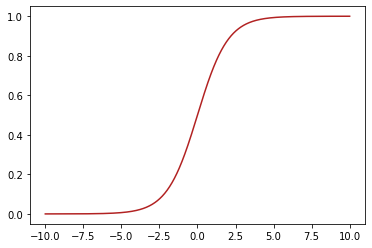

In [8]:
theta = 0.
plt.plot(np.linspace(-10, 10, 1000), S(np.linspace(-10, 10, 1000), theta))
plt.show()

The neural network aim at learn a binary sequence $y \in \{0, 1\}^n$ (or more specifically a periodic binary sequence).

In [9]:
seq = backward_filtering_forward_sampling(n, Nr)

The fitting loss function is given by
\begin{equation}
L_f (w) = -\frac{1}{n} \sum_{k=1}^n y_k \log (h_{w, \theta}(z_k)) + (1-y_k) \log (1- h_{w, \theta}(z_k)) 
\end{equation}

In reality, we use $\tilde{n}$ instead of $n$, corresponding to the number of free position in the sequence. Obviously, we have $\tilde{n} \leq n$.


This loss function is convex, so using gradient descent, we converge to the optimal solution. The gradient of the fitting loss function is given by:
\begin{equation}
\frac{\partial}{\partial w_i} L_f (w) = \frac{1}{n} \sum_{k=1}^n (h_{w, \theta}(z_k) - y_k) z_{k, i}
\end{equation}
The gradient descent weight update rule is:
\begin{equation}
w \leftarrow w - \eta \cdot \nabla_w L_f (w),
\end{equation}
with some learning rate parameter $\eta > 0$.

In [10]:
loss_fit = lambda w, z, y : -np.mean(y * np.log(S(np.inner(w, z), theta)) + (1-y) * np.log(1-S(np.inner(w, z), theta)))
grad_loss_fit = lambda w, z, y : (1/n * np.dot(S(np.inner(w, z), theta) - y, z))
eta = 1.

In [11]:
free_indices = [k for k in range(n) if np.sum(np.roll(seq, -k)[...,-Nr:]) < 1]
n_ = len(free_indices)
z = np.random.uniform(0, 1, (n_, m))
y = seq[free_indices]

In [12]:
w = np.random.uniform(-1, 1, (m))
for _ in range(10000):
    w -= eta * grad_loss_fit(w, z, y)

In [13]:
y_hat = np.inner(w, z) > theta
seq_hat = np.zeros(n, dtype=int)
seq_hat[free_indices] = y_hat

In [14]:
hamming_dist(seq_hat, seq)

0

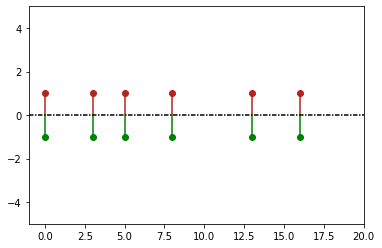

In [15]:
firing_pos = np.argwhere(seq > 0)
hat_firing_pos = np.argwhere(seq_hat > 0)
plt.stem(hat_firing_pos, seq_hat[hat_firing_pos], basefmt=" ")
plt.stem(firing_pos, - seq[firing_pos], linefmt="C1-", markerfmt="C1o", basefmt=" ")
plt.axhline(0, linestyle=(0, (3, 1, 1, 1)), color="black")
plt.ylim(-5, 5)
plt.xlim(-1, n)
plt.show()

For robustness consideration, we are interested in the distribution of the weights

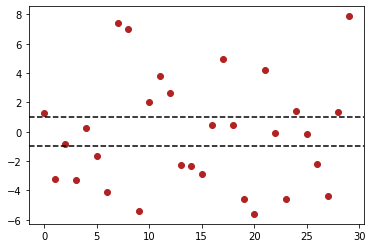

In [16]:
plt.scatter(np.arange(m), w)
plt.axhline(-1, linestyle="dashed", color="black")
plt.axhline(1, linestyle="dashed", color="black")

# With bounded weights

An extended version of the logistic regression to bound weights can be used. We start noticing that the absolute function can be approximate by the twice differentiable function
\begin{equation}
|x| \simeq \sqrt{x^2 + c}
\end{equation}
with $c > 0$ arbitrarily small.

One can easily prove that this function is stricly convex, as its second derivative is stricly positive.

In [17]:
abs_app = lambda x : np.sqrt(np.square(x) + 1e-2)

In [18]:
x = np.linspace(-2, 2, 1000)

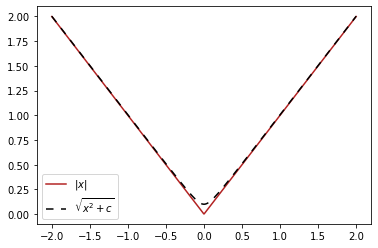

In [19]:
plt.plot(x, np.abs(x))
plt.plot(x, abs_app(x), linestyle=(0, (5,5)), color="black")
plt.legend([r"$|x|$", r"$\sqrt{x^2 + c}$"])
plt.show()

Using this approximation, we can use a regularization loss function to enforce the weights being in a specific range $[a, b]$:
\begin{equation}
L_r(w) = \sum_{i=1}^m |w_i - a| + |w_i - b| - 2 \simeq \sum_{i=1}^m \sqrt{(w_i-a)^2 + c} + \sqrt{(w_i-b)^2 + c} - 2
\end{equation}
with small $c > 0$.

The partial derivative of the regularization loss function w.r.t each weight is given by:
\begin{equation}
\frac{\partial}{\partial w_i} L_r(w) = \frac{w_i - a}{\sqrt{(w_i-a)^2 + c}} + \frac{w_i - b}{\sqrt{(w_i-b)^2 + c}}
\end{equation}

This reguralization loss function is also convex, being a sum of convex functions.

In [20]:
loss_reg = lambda w : np.sum(abs_app(w-a) + abs_app(w-b) - np.abs(b-a))
grad_loss_reg = lambda w : (w - a)/abs_app(w-a) + (w - b)/abs_app(w-b)

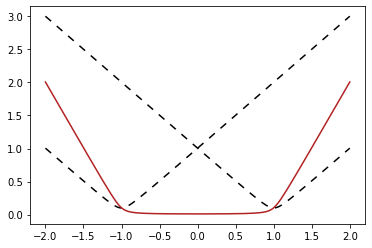

In [21]:
a, b = (-1, 1)
plt.plot(x, abs_app(x - a), x, abs_app(x-b), linestyle=(0, (5,5)), c="black")
plt.plot(x, abs_app(x - a) + abs_app(x-b) - np.abs(b-a))
plt.show()

Combining the fitting and the reguralization loss functions, we can optimize the weights such that they fit well the sequence to learn and are bounded. The mixing loss function is 
\begin{equation}
L (w) = L_f(w) + \alpha L_r(w)
\end{equation}
where $\alpha \leq 0$ is a balancing parameter. As a sum of convex function, this is also a convex function and it can be optimize via gradient descent.
The gradient of the mixing loss function is given by 
\begin{equation}
\nabla_w L (w) = \nabla_w L_f(w) + \alpha \cdot \nabla_w L_r(w)
\end{equation}
The gradient descent update rule for the weights is then
\begin{equation}
w \leftarrow w + \eta \cdot \nabla_w L(w),
\end{equation}
with $\eta > 0$ the learning rate.

In [22]:
# Total Loss = Fitting Loss + Bound Loss
alpha = 0.5
loss = lambda w, z, y : loss_fit(w, z, y) + alpha * loss_reg(w)
grad_loss = lambda w, z, y : grad_loss_fit(w, z, y) + alpha * grad_loss_reg(w)

In [23]:
w = np.random.uniform(-1, 1, (m))
for _ in range(10000):
    w -= eta * grad_loss(w, z, y)

In [24]:
y_hat = np.inner(w, z) > theta
seq_hat = np.zeros(n, dtype=int)
seq_hat[free_indices] = y_hat

In [25]:
hamming_dist(seq_hat, seq)

0

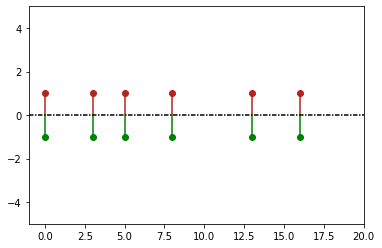

In [26]:
firing_pos = np.argwhere(seq > 0)
hat_firing_pos = np.argwhere(seq_hat > 0)
plt.stem(hat_firing_pos, seq_hat[hat_firing_pos], basefmt=" ")
plt.stem(firing_pos, - seq[firing_pos], linefmt="C1-", markerfmt="C1o", basefmt=" ")
plt.axhline(0, linestyle=(0, (3, 1, 1, 1)), color="black")
plt.ylim(-5, 5)
plt.xlim(-1, n)
plt.show()

We verify the weights are bounded as imposed by our regularization loss function.

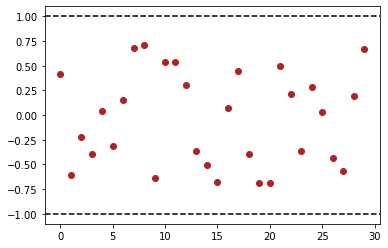

In [27]:
plt.scatter(np.arange(m), w)
plt.axhline(-1, linestyle="dashed", color="black")
plt.axhline(1, linestyle="dashed", color="black")